# Experiment to collect time for checkpoint (tc)

- Date: 29.09.2021
- Execution: DOS ARM Spark K8s cluster
- Workload Apps: 
    - `gbt`: training and testing a *Gradient Boosted Trees* Regressor
    - `analytics`: joining and aggregating transaction data from E-commerce 
- Checkpoint Interval: every 2 iterations for `gbt`
- Again: Only the Analytics workloads wrote files on HDFS


| **Workload App**         | **Checkpoint**     | **Input size** | **Drivers**         | **Driver Cores**     |**Driver Memory** |**Executors** |**Executors Cores** |**Executors Memory** |**Iterations** | **Checkpoint size** |
|--------------|-----------|------------|--------------|-----------|------------|------------|------------|------------|------------|------------|
| gbt | NO      | 35 GB        | 1 | 4      | 4 GB        | 10        | 4        | 8 GB    |5        | / |
| gbt-checkpoint      | YES  | 35 GB       | 1      | 4  | 4 GB       | 10        | 4        | 8 GB | 5 | 0  |
| analytics      | NO  | 32 GB       | 1      | 4  | 4 GB       | 10       | 4        | 8 GB | 5  | /  |
| analytics-checkpoint | YES  | 32 GB       | 1      | 4  | 4 GB       | 10       | 4        | 8 GB | 5 | 40GB


# Analysis

## Data preparation

In [312]:
from pyspark.sql import types as T
from pyspark.sql import functions as F
from pyspark.sql import DataFrame

In [313]:
def cast(gbt_df: DataFrame) -> DataFrame:
    # cast numeric and datetime columns
    datetime_pattern = "yyyy-MM-dd'T'HH:mm:ss.SSSz"

    gbt_df = gbt_df.select(
        "*",
        gbt_df.taskIndex.cast(T.IntegerType()).alias("taskIndex_"),
        gbt_df.rddId.cast(T.IntegerType()).alias("rddId_"),
        gbt_df.taskAttempt.cast(T.IntegerType()).alias("taskAttempt_"),
        gbt_df.taskDuration.cast(T.FloatType()).alias("taskDuration_"),
        gbt_df.taskExecutorId.cast(T.IntegerType()).alias("taskExecutorId_"),
        gbt_df.tcMs.cast(T.FloatType()).alias("tcMs_"),
        F.to_timestamp(gbt_df.submissionTime, datetime_pattern).alias("submissionTime_"),
        F.to_timestamp(gbt_df.firstTaskLaunchedTime, datetime_pattern).alias("firstTaskLaunchedTime_"),
        F.to_timestamp(gbt_df.completionTime, datetime_pattern).alias("completionTime_"),
        F.to_timestamp(gbt_df.taskLaunchTime, datetime_pattern).alias("taskLaunchTime_")
    ).drop("taskIndex", "rddId", "taskId", "tcMs",
           "taskAttempt", "taskDuration", "taskExecutorId", "submissionTime",
           "firstTaskLaunchedTime", "completionTime", "taskLaunchTime")
    
    # rename columns
    new_column_names = [c.rstrip("_") for c in gbt_df.columns]
    gbt_df = gbt_df.toDF(*new_column_names)

    gbt_df = gbt_df.withColumnRenamed("_c0", "id")
    
    return gbt_df

In [314]:
gbt_df = spark.read.csv(
    path="../output/cluster/GradientBoostedTrees/spark-4f315e53e8a14b8bb8e7e7553cab59c9_normal.csv",
    sep=",",
    header=True,
    inferSchema=True
)

In [315]:
gbt_check_df = spark.read.csv(
    path="../output/cluster/GradientBoostedTrees/spark-21eb97c0b76a4aeaa9e93282e926c9f3_checkpoint.csv",
    sep=",",
    header=True,
    inferSchema=True
)

### join each of the 5 `Analytics` workload run DataFrames together 

In [316]:
first_analytics_run_path = "../output/cluster/Analytics/spark-9078bc6ddb3a4c0b913072d827c939bc_normal.csv"
# key: the sequence of execution, value: the path of the output of run_experiments.py
analytics_df_runs = {
    "2": "../output/cluster/Analytics/spark-827da77e3d5946b395e7359bb0534f22_normal.csv",
    "3": "../output/cluster/Analytics/spark-ab3aa599abf141568bed1c53aee2f842_normal.csv",
    "4": "../output/cluster/Analytics/spark-f9330f93633948d195315dbeba6313f2_normal.csv",
    "5": "../output/cluster/Analytics/spark-af529ab0a80b48168d3c95c60bf7bca7_normal.csv"
}
analytics_df = spark.read.csv(
    path=first_analytics_run_path,
    sep=",",
    header=True,
    inferSchema=True
)

analytics_df = cast(analytics_df)

rows_before_join = analytics_df.count()
print(f"rows_before_join: {rows_before_join}")

for key, value in analytics_df_runs.items():
    df_inc = spark.read.csv(
        path=value,
        sep=",",
        header=True,
        inferSchema=True
    )
    
    df_inc = cast(df_inc)
    
    # add suffix to the incrementing dataframe
    df_inc = df_inc.select([F.col(c).alias(f"{c}_{key}") for c in df_inc.columns])
    
    # add join column
    df_inc = df_inc.withColumn("id", F.monotonically_increasing_id())
    
    # of these columns, we use the mean of the 5 runs
    mean_cols = [
        "id",
        df_inc.columns[6],  # numCompleteTasks
        df_inc.columns[7],  # numFailedTasks
        df_inc.columns[8],  # numKilledTasks
        df_inc.columns[13],  # taskAttempt
        df_inc.columns[14],  # taskDuration
        df_inc.columns[17],  # (Stage)submissionTime (for duration)
        df_inc.columns[19]  # (Stage)completionTime (for duration)
    ]
    
    analytics_df = analytics_df.join(
        df_inc.select(mean_cols),
        on="id",
        how="inner"
    )


rows_after_join = analytics_df.count()
print(f"rows_after_join: {rows_after_join}")

assert rows_after_join == rows_before_join

rows_before_join: 1392
rows_after_join: 1392


In [317]:
first_run_path = "../output/cluster/Analytics/spark-d493e730d6be481896910ff2a003db4e_checkpoint.csv"
# key: the sequence of execution, value: the path of the output of run_experiments.py
analytics_check_df_runs = {
    "2": "../output/cluster/Analytics/spark-86ce2033320d452ebfb4c69e0d5aaaad_checkpoint.csv",
    "3": "../output/cluster/Analytics/spark-581a0b09967648cca77d0084ed25af2f_checkpoint.csv",
    "4": "../output/cluster/Analytics/spark-83e529840d2c4c0eb550105373fed434_checkpoint.csv",
    "5": "../output/cluster/Analytics/spark-4c736126ec9a4b72a96a76c1155cd03e_checkpoint.csv"
}
analytics_check_df = spark.read.csv(
    path=first_run_path,
    sep=",",
    header=True,
    inferSchema=True
)

analytics_check_df = cast(analytics_check_df)

rows_before_join = analytics_check_df.count()
print(f"rows_before_join: {rows_before_join}")

for key, value in analytics_check_df_runs.items():
    df = spark.read.csv(
        path=value,
        sep=",",
        header=True,
        inferSchema=True
    )
    
    df = cast(df)
    
    
    # add suffix to the incrementing dataframe
    df = df.select([F.col(c).alias(f"{c}_{key}") for c in df.columns])
    
    # add join column
    df = df.withColumn("id", F.monotonically_increasing_id())
    
    # of these columns, we use the mean of the 5 runs
    mean_cols = [
        "id",
        df.columns[6],  # numCompleteTasks
        df.columns[7],  # numFailedTasks
        df.columns[8],  # numKilledTasks
        df.columns[13],  # taskAttempt
        df.columns[14],  # taskDuration
        df.columns[16],  # tcMs
        df.columns[17],  # (Stage)submissionTime (for duration)
        df.columns[19]  # (Stage)completionTime (for duration)
    ]
    
    analytics_check_df = analytics_check_df.join(
        df.select(mean_cols),
        on="id",
        how="inner"
    )
    


rows_after_join = analytics_check_df.count()
print(f"rows_after_join: {rows_after_join}")

assert rows_after_join == rows_before_join

rows_before_join: 10152
rows_after_join: 10152


In [318]:
analytics_check_df

DataFrame[id: int, status: string, stageId: int, attemptId: int, numTasks: int, numActiveTasks: int, numCompleteTasks: int, numFailedTasks: int, numKilledTasks: int, name: string, rddIds: string, taskIndex: int, rddId: int, taskAttempt: int, taskDuration: float, taskExecutorId: int, tcMs: float, submissionTime: timestamp, firstTaskLaunchedTime: timestamp, completionTime: timestamp, taskLaunchTime: timestamp, numCompleteTasks_2: int, numFailedTasks_2: int, numKilledTasks_2: int, taskAttempt_2: int, taskDuration_2: float, tcMs_2: float, submissionTime_2: timestamp, completionTime_2: timestamp, numCompleteTasks_3: int, numFailedTasks_3: int, numKilledTasks_3: int, taskAttempt_3: int, taskDuration_3: float, tcMs_3: float, submissionTime_3: timestamp, completionTime_3: timestamp, numCompleteTasks_4: int, numFailedTasks_4: int, numKilledTasks_4: int, taskAttempt_4: int, taskDuration_4: float, tcMs_4: float, submissionTime_4: timestamp, completionTime_4: timestamp, numCompleteTasks_5: int, nu

## 1.3 calculate the mean of the values that were collected over all 5 runs in the `Analytics` workload

In [319]:
analytics_df = analytics_df.withColumn(
    "meanNumCompleteTasks",
    ((F.col("numCompleteTasks") + F.col("numCompleteTasks_2") + F.col("numCompleteTasks_3") + F.col("numCompleteTasks_4") + F.col("numCompleteTasks_5")) / 5)
)

analytics_df = analytics_df.withColumn(
    "meanNumFailedTasks",
    ((F.col("numFailedTasks") + F.col("numFailedTasks_2") + F.col("numFailedTasks_3") + F.col("numFailedTasks_4") + F.col("numFailedTasks_5")) / 5)
)

analytics_df = analytics_df.withColumn(
    "meanNumKilledTasks",
    ((F.col("numKilledTasks") + F.col("numKilledTasks_2") + F.col("numKilledTasks_3") + F.col("numKilledTasks_4") + F.col("numKilledTasks_5")) / 5)
)

analytics_df = analytics_df.withColumn(
    "meanTaskAttempt",
    ((F.col("taskAttempt") + F.col("taskAttempt_2") + F.col("taskAttempt_3") + F.col("taskAttempt_4") + F.col("taskAttempt_5")) / 5)
)

analytics_df = analytics_df.withColumn(
    "meanTaskAttempt",
    ((F.col("taskAttempt") + F.col("taskAttempt_2") + F.col("taskAttempt_3") + F.col("taskAttempt_4") + F.col("taskAttempt_5")) / 5)
)

analytics_df = analytics_df.withColumn(
    "meanTaskDuration",
    ((F.col("taskDuration") + F.col("taskDuration_2") + F.col("taskDuration_3") + F.col("taskDuration_4") + F.col("taskDuration_5")) / 5)
)

In [320]:
analytics_check_df = analytics_check_df.withColumn(
    "meanNumCompleteTasks",
    ((F.col("numCompleteTasks") + F.col("numCompleteTasks_2") + F.col("numCompleteTasks_3") + F.col("numCompleteTasks_4") + F.col("numCompleteTasks_5")) / 5)
)

analytics_check_df = analytics_check_df.withColumn(
    "meanNumFailedTasks",
    ((F.col("numFailedTasks") + F.col("numFailedTasks_2") + F.col("numFailedTasks_3") + F.col("numFailedTasks_4") + F.col("numFailedTasks_5")) / 5)
)

analytics_check_df = analytics_check_df.withColumn(
    "meanNumKilledTasks",
    ((F.col("numKilledTasks") + F.col("numKilledTasks_2") + F.col("numKilledTasks_3") + F.col("numKilledTasks_4") + F.col("numKilledTasks_5")) / 5)
)

analytics_check_df = analytics_check_df.withColumn(
    "meanTaskAttempt",
    ((F.col("taskAttempt") + F.col("taskAttempt_2") + F.col("taskAttempt_3") + F.col("taskAttempt_4") + F.col("taskAttempt_5")) / 5)
)

analytics_check_df = analytics_check_df.withColumn(
    "meanTaskAttempt",
    ((F.col("taskAttempt") + F.col("taskAttempt_2") + F.col("taskAttempt_3") + F.col("taskAttempt_4") + F.col("taskAttempt_5")) / 5)
)

analytics_check_df = analytics_check_df.withColumn(
    "meanTaskDuration",
    ((F.col("taskDuration") + F.col("taskDuration_2") + F.col("taskDuration_3") + F.col("taskDuration_4") + F.col("taskDuration_5")) / 5)
)

analytics_check_df = analytics_check_df.withColumn(
    "meanTcMs",
    ((F.col("tcMs") + F.col("tcMs_2") + F.col("tcMs_3") + F.col("tcMs_4") + F.col("tcMs_5")) / 5)
)

In [321]:
gbt_df = cast(gbt_df)

In [322]:
gbt_df

DataFrame[id: int, status: string, stageId: int, attemptId: int, numTasks: int, numActiveTasks: int, numCompleteTasks: int, numFailedTasks: int, numKilledTasks: int, name: string, rddIds: string, taskIndex: int, rddId: int, taskAttempt: int, taskDuration: float, taskExecutorId: int, tcMs: float, submissionTime: timestamp, firstTaskLaunchedTime: timestamp, completionTime: timestamp, taskLaunchTime: timestamp]

In [323]:
gbt_check_df = cast(gbt_check_df)

## 1.4 Data summary

### `GBT`
- 16 as maximum for `numCompleteTasks` make sense since 4 executors with 4 cores each can compute maximum 16 tasks in parallel
- 4 as maximum for `numFailedTasks` means that no cores were available anymore, thus the executor failed

In [324]:
gbt_df.select("numCompleteTasks", "numFailedTasks", "numKilledTasks", "taskAttempt", "taskDuration").summary().show()

+-------+-----------------+--------------+--------------+-----------+------------+
|summary| numCompleteTasks|numFailedTasks|numKilledTasks|taskAttempt|taskDuration|
+-------+-----------------+--------------+--------------+-----------+------------+
|  count|           891136|        891136|        891136|      15104|      891136|
|   mean|            256.0|           0.0|           0.0|        0.0|         NaN|
| stddev|75.62287998199473|           0.0|           0.0|        0.0|         NaN|
|    min|                1|             0|             0|          0|         2.0|
|    25%|              279|             0|             0|          0|         NaN|
|    50%|              279|             0|             0|          0|         NaN|
|    75%|              279|             0|             0|          0|         NaN|
|    max|              279|             0|             0|          0|         NaN|
+-------+-----------------+--------------+--------------+-----------+------------+



In [325]:
gbt_check_df.select("numCompleteTasks", "numFailedTasks", "numKilledTasks", "taskAttempt", "taskDuration", "tcMs").summary().show()

+-------+------------------+--------------+--------------+-----------+------------+-------+
|summary|  numCompleteTasks|numFailedTasks|numKilledTasks|taskAttempt|taskDuration|   tcMs|
+-------+------------------+--------------+--------------+-----------+------------+-------+
|  count|            955382|        955382|        955382|      15662|      955382| 955382|
|   mean|256.75409836065575|           0.0|           0.0|        0.0|         NaN|    NaN|
| stddev|  74.4855212814262|           0.0|           0.0|        0.0|         NaN|    NaN|
|    min|                 1|             0|             0|          0|         2.0| 5265.0|
|    25%|               279|             0|             0|          0|         NaN|10024.0|
|    50%|               279|             0|             0|          0|         NaN|10024.0|
|    75%|               279|             0|             0|          0|         NaN|    NaN|
|    max|               279|             0|             0|          0|         N

### `Analytics`
- higher number of tasks per stage
- no failed or killed tasks
- higher task and checkpoint duration than `GBT`

In [326]:
analytics_df.select("meanNumCompleteTasks", "meanNumFailedTasks", "meanNumKilledTasks", "meanTaskAttempt", "meanTaskDuration").summary().show()

+-------+--------------------+------------------+------------------+---------------+----------------+
|summary|meanNumCompleteTasks|meanNumFailedTasks|meanNumKilledTasks|meanTaskAttempt|meanTaskDuration|
+-------+--------------------+------------------+------------------+---------------+----------------+
|  count|                1392|              1392|              1392|            392|            1392|
|   mean|  154.66666666666603|               0.0|               0.0|            0.0|             NaN|
| stddev|   32.60182691415348|               0.0|               0.0|            0.0|             NaN|
|    min|               124.8|               0.0|               0.0|            0.0|          5024.4|
|    25%|               124.8|               0.0|               0.0|            0.0|        121666.8|
|    50%|               139.2|               0.0|               0.0|            0.0|             NaN|
|    75%|               200.0|               0.0|               0.0|            0.

In [327]:
analytics_check_df.select("meanNumCompleteTasks", "meanNumFailedTasks", "meanNumKilledTasks", "meanTaskAttempt", "meanTaskDuration", "meanTcMs").summary().show()

+-------+--------------------+-------------------+------------------+--------------------+----------------+--------+
|summary|meanNumCompleteTasks| meanNumFailedTasks|meanNumKilledTasks|     meanTaskAttempt|meanTaskDuration|meanTcMs|
+-------+--------------------+-------------------+------------------+--------------------+----------------+--------+
|  count|               10152|              10152|             10152|                 696|           10152|   10152|
|   mean|  125.35413711584937|0.26950354609929644|               0.0|5.747126436781609E-4|             NaN|     NaN|
| stddev|   73.69446727916542| 0.7577815732807799|               0.0|0.010713409532086398|             NaN|     NaN|
|    min|                 0.0|                0.0|               0.0|                 0.0|          6588.4|204511.6|
|    25%|               110.4|                0.0|               0.0|                 0.0|             NaN|     NaN|
|    50%|               140.8|                0.0|              

In [328]:
gbt_check_df.select("tcMs", "rddId").distinct().sort("rddId").show(10)

+-------+-----+
|   tcMs|rddId|
+-------+-----+
|    NaN| null|
|10024.0|   68|
| 5265.0|  113|
+-------+-----+



In [329]:
analytics_check_df.select("meanTcMs", "rddId").distinct().sort("rddId").show(10)

+--------+-----+
|meanTcMs|rddId|
+--------+-----+
|     NaN| null|
|204511.6|   14|
|     NaN|   14|
+--------+-----+



### *Plot 1*: total App runtime compared

In [336]:
gbt_runtime = gbt_df.select(
    F.min("submissionTime").alias("start"),
    F.max("completionTime").alias("end"),
    (F.max("completionTime").cast(T.LongType()) - F.min("submissionTime").cast(T.LongType())).alias("duration")  # in seconds
).select("duration").collect()[0][0] # in seconds

print(f"GBT runtimes: {gbt_runtime}")

analytics_runtime = analytics_df.select(
    F.min("submissionTime").alias("start"),
    F.min("submissionTime_2").alias("start_2"),
    F.min("submissionTime_3").alias("start_3"),
    F.min("submissionTime_4").alias("start_4"),
    F.min("submissionTime_5").alias("start_5"),
    F.max("completionTime").alias("end"),
    F.max("completionTime_2").alias("end_2"),
    F.max("completionTime_3").alias("end_3"),
    F.max("completionTime_4").alias("end_4"),
    F.max("completionTime_5").alias("end_5"),
    (F.max("completionTime").cast(T.LongType()) - F.min("submissionTime").cast(T.LongType())).alias("duration"),  
    (F.max("completionTime_2").cast(T.LongType()) - F.min("submissionTime_2").cast(T.LongType())).alias("duration_2"),
    (F.max("completionTime_3").cast(T.LongType()) - F.min("submissionTime_3").cast(T.LongType())).alias("duration_3"),
    (F.max("completionTime_4").cast(T.LongType()) - F.min("submissionTime_4").cast(T.LongType())).alias("duration_4"),
    (F.max("completionTime_5").cast(T.LongType()) - F.min("submissionTime_5").cast(T.LongType())).alias("duration_5")
).select("duration", "duration_2", "duration_3", "duration_4", "duration_5").collect()[0]  # in seconds

print(f"Analytics runtimes: {analytics_runtime}")

analytics_check_runtime = analytics_check_df.select(
    F.min("submissionTime").alias("start"),
    F.min("submissionTime_2").alias("start_2"),
    F.min("submissionTime_3").alias("start_3"),
    F.min("submissionTime_4").alias("start_4"),
    F.min("submissionTime_5").alias("start_5"),
    F.max("completionTime").alias("end"),
    F.max("completionTime_2").alias("end_2"),
    F.max("completionTime_3").alias("end_3"),
    F.max("completionTime_4").alias("end_4"),
    F.max("completionTime_5").alias("end_5"),
    (F.max("completionTime").cast(T.LongType()) - F.min("submissionTime").cast(T.LongType())).alias("duration"),  
    (F.max("completionTime_2").cast(T.LongType()) - F.min("submissionTime_2").cast(T.LongType())).alias("duration_2"),
    (F.max("completionTime_3").cast(T.LongType()) - F.min("submissionTime_3").cast(T.LongType())).alias("duration_3"),
    (F.max("completionTime_4").cast(T.LongType()) - F.min("submissionTime_4").cast(T.LongType())).alias("duration_4"),
    (F.max("completionTime_5").cast(T.LongType()) - F.min("submissionTime_5").cast(T.LongType())).alias("duration_5")
).select("duration", "duration_2", "duration_3", "duration_4", "duration_5").collect()[0]  # in seconds

print(f"Analytics check runtimes: {analytics_check_runtime}")

gbt_check_runtime = gbt_check_df.select(
    F.min("submissionTime").alias("start"),
    F.max("completionTime").alias("end"),
    (F.max("completionTime").cast(T.LongType()) - F.min("submissionTime").cast(T.LongType())).alias("duration")  # in seconds
).select("duration").collect()[0][0] # in seconds

print(f"GBT check runtime: {gbt_check_runtime}")


GBT runtimes: 1348
Analytics runtimes: Row(duration=803, duration_2=714, duration_3=751, duration_4=628, duration_5=621)
Analytics check runtimes: Row(duration=1903, duration_2=1616, duration_3=1588, duration_4=1728, duration_5=1380)
GBT check runtime: 1193


11.723333333333333


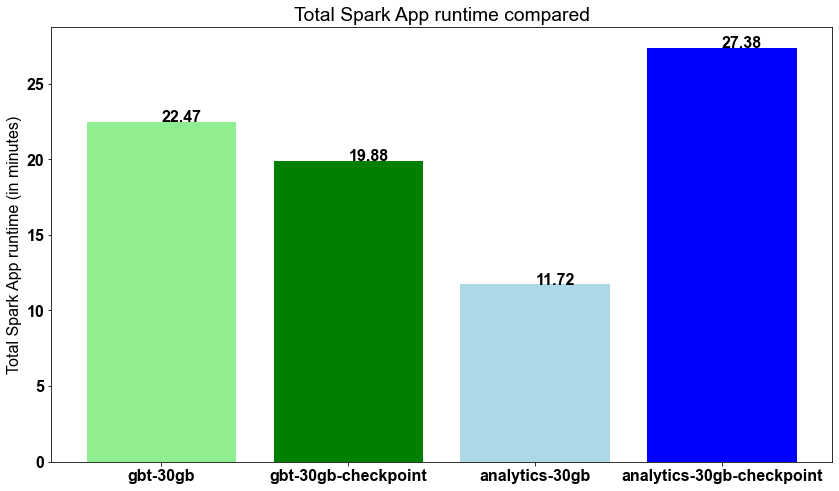

In [340]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

font = {'family' : 'arial',
        'weight' : 'bold',
        'size'   : 16}

plt.rc('font', **font)


labels = ['gbt-30gb', 'gbt-30gb-checkpoint', 'analytics-30gb', 'analytics-30gb-checkpoint']

analytics_mean_runtime = ( sum(analytics_runtime) / len(analytics_runtime) ) / 60
analytics_mean_check_runtime = ( sum(analytics_check_runtime) / len(analytics_check_runtime) ) / 60
runtimes = [(gbt_runtime / 60), (gbt_check_runtime / 60), analytics_mean_runtime, analytics_mean_check_runtime,]


fig, ax = plt.subplots()
fig.set_size_inches(14, 8)

ax.bar(labels, runtimes, label='App runtime (mean for analytics) (in minutes)', color=["lightgreen", "green", "lightblue", "blue"])

# annotate the values to the bars
for i,j in zip(labels,runtimes):
    ax.annotate(str(format(j, '.2f')),xy=(i,j))

ax.set_ylabel('Total Spark App runtime (in minutes)')
ax.set_title('Total Spark App runtime compared')

plt.show()

In [ ]:
print(f"In sum, checkpointing in the GBT workload took: {gbt_tcMs_sum_seconds} seconds")

In [ ]:
print(f"In sum, checkpointing in the Analytics workloads took (mean): {analytics_tcMs_sum_seconds} seconds ({analytics_tcMs_sum_seconds/60} minutes)")

### *Plot 1.1*: total App runtime compared over `Analytics` runs

<ipython-input-341-4911ed504e2a>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation = 90)


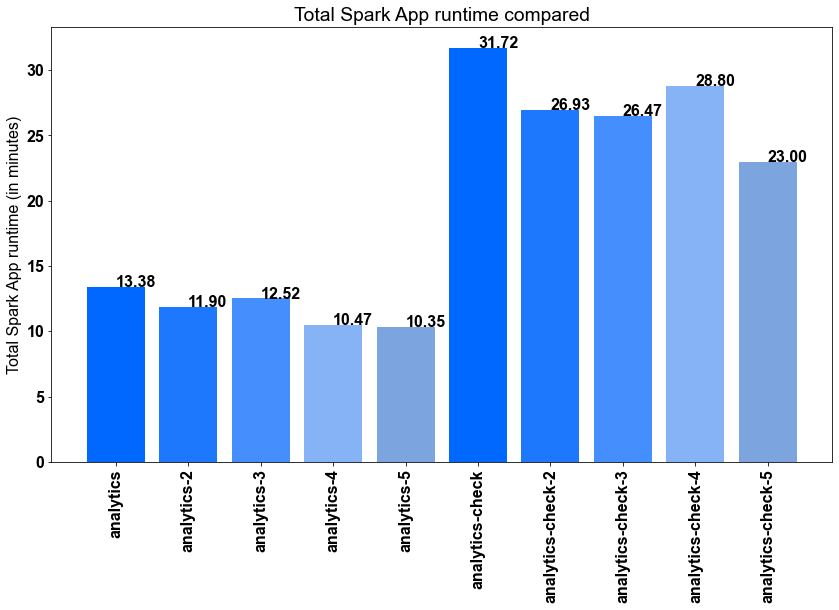

In [341]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

font = {'family' : 'arial',
        'weight' : 'bold',
        'size'   : 16}

plt.rc('font', **font)


labels = ['analytics', 'analytics-2', 'analytics-3', 'analytics-4', 'analytics-5', 'analytics-check', 'analytics-check-2', 'analytics-check-3', 'analytics-check-4', 'analytics-check-5']

# list index indicates run sequence
analytics_runtime_list = []
analytics_check_runtime_list = []
for i, j in zip(analytics_runtime, analytics_check_runtime):
    analytics_runtime_list.append(i / 60)
    analytics_check_runtime_list.append(j / 60)


runtimes = analytics_runtime_list + analytics_check_runtime_list

fig, ax = plt.subplots()
fig.set_size_inches(14, 8)

ax.bar(labels, runtimes, label='App runtime (in minutes)', color=["#0067ff", "#1e78fd", "#448ffd", "#86b3f5", "#7ca4de"])

# annotate the values to the bars
for i,j in zip(labels,runtimes):
    ax.annotate(str(format(j, '.2f')),xy=(i,j))

ax.set_ylabel('Total Spark App runtime (in minutes)')
ax.set_title('Total Spark App runtime compared')
ax.set_xticklabels(labels, rotation = 90)

plt.show()

### *Plot 1.2*: total `tcMs`  over `Analytics` runs

In [281]:
analytics_check_tcMs = analytics_check_df.filter(
    (~F.isnan(F.col("tcMs"))) &
    (~F.isnan(F.col("meanTcMs")))
).select("tcMs", "tcMs_2", "tcMs_3", "tcMs_4", "tcMs_5", "meanTcMs").distinct().collect()[0]  # in ms

print(analytics_check_tcMs)

Row(tcMs=214827.0, tcMs_2=152224.0, tcMs_3=282870.0, tcMs_4=237603.0, tcMs_5=135034.0, meanTcMs=204511.6)


<ipython-input-301-e5a4693442ff>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation = 90)


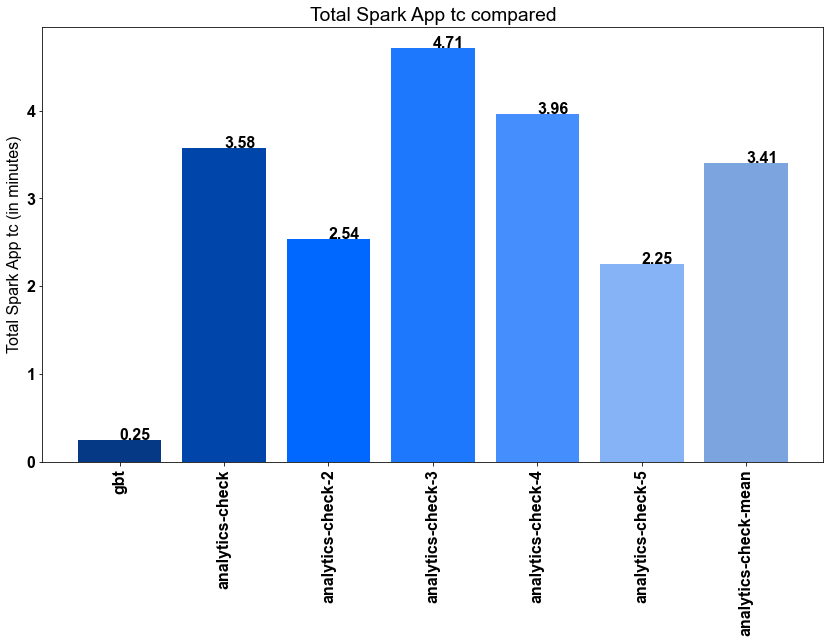

In [301]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

font = {'family' : 'arial',
        'weight' : 'bold',
        'size'   : 16}

plt.rc('font', **font)


labels = ['gbt','analytics-check', 'analytics-check-2', 'analytics-check-3', 'analytics-check-4', 'analytics-check-5', 'analytics-check-mean']

# list index indicates run sequence
gbt_check_tcMs_list = [gbt_tcMs_sum_seconds / 60]
analytics_check_tcMs_list = []
for i in analytics_check_tcMs:
    analytics_check_tcMs_list.append(i / 60000)  # in minutes


tcMs = gbt_check_tcMs_list + analytics_check_tcMs_list

fig, ax = plt.subplots()
fig.set_size_inches(14, 8)

ax.bar(labels, tcMs, label='tcMs runtime (in minutes)', color=["#053985","#0045aa", "#0067ff", "#1e78fd", "#448ffd", "#86b3f5", "#7ca4de"])
# annotate the values to the bars
for i,j in zip(labels,tcMs):
    ax.annotate(str(format(j, '.2f')),xy=(i,j))

ax.set_ylabel('Total Spark App tc (in minutes)')
ax.set_title('Total Spark App tc compared')
ax.set_xticklabels(labels, rotation = 90)

plt.show()

### *Plot 2*: GBT `tc` over time

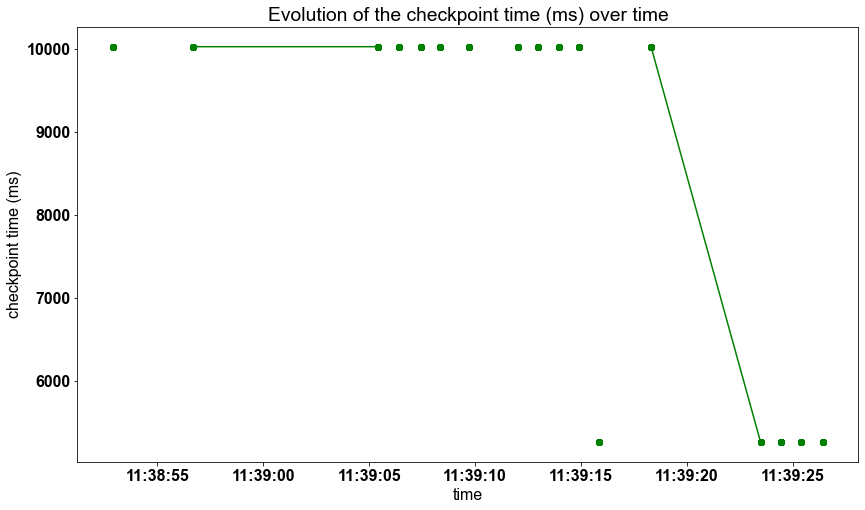

In [89]:
gbt_check_submission_time = gbt_check_df.select("submissionTime").toPandas()["submissionTime"]
gbt_tc_ms = gbt_check_df.select("tcMs").toPandas()["tcMs"]

fig = plt.figure(figsize=(14, 8))

plt.plot(gbt_check_submission_time, gbt_tc_ms, '-o', color="green")

plt.xlabel('time')
plt.ylabel('checkpoint time (ms)')
plt.title('Evolution of the checkpoint time (ms) over time')

plt.show()

### *Plot 3*: Analytics `tcMs` over time

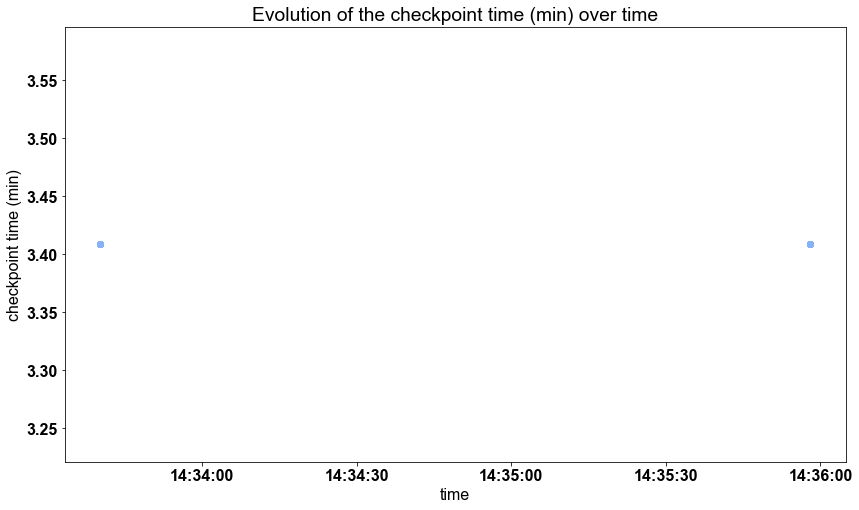

In [291]:
analytics_check_submission_time = analytics_check_df.select("submissionTime").toPandas()["submissionTime"]
analytics_tc_ms = analytics_check_df.select("meanTcMs").toPandas()["meanTcMs"] / 60000

fig = plt.figure(figsize=(14, 8))
color=["#053985","#0045aa", "#0067ff", "#1e78fd", "#448ffd", "#86b3f5", "#7ca4de"]
plt.plot(analytics_check_submission_time, analytics_tc_ms, '-o', color=color[5])

plt.xlabel('time')
plt.ylabel('checkpoint time (min)')
plt.title('Evolution of the checkpoint time (min) over time')

plt.show()

### *Plot 3*: GBT: Failed and completed tasks per stage over time

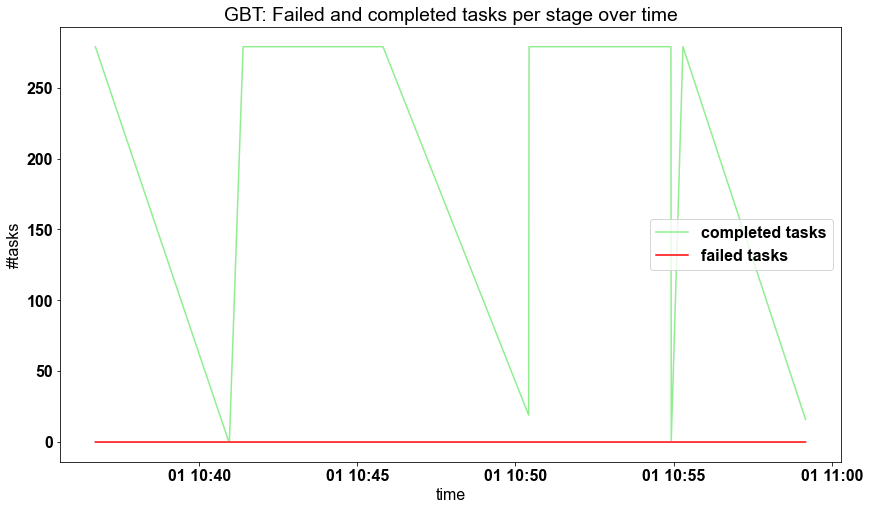

In [293]:
gbt_submission_time = gbt_df.select("submissionTime").toPandas()["submissionTime"]

gbt_complete_tasks = gbt_df.select("numCompleteTasks").toPandas()["numCompleteTasks"]
gbt_failed_tasks = gbt_df.select("numFailedTasks").toPandas()["numFailedTasks"]

gbt_check_complete_tasks = gbt_check_df.select("numCompleteTasks").toPandas()["numCompleteTasks"]
gbt_check_failed_tasks = gbt_check_df.select("numFailedTasks").toPandas()["numFailedTasks"]


fig = plt.figure(figsize=(14, 8))

plt.plot(gbt_submission_time, gbt_complete_tasks, color="lightgreen", label="completed tasks")
plt.plot(gbt_submission_time, gbt_failed_tasks, color="red", label="failed tasks")

plt.xlabel('time')
plt.ylabel('#tasks')
plt.title('GBT: Failed and completed tasks per stage over time')
plt.legend()

plt.show()

### *Plot 4*: GBT: Failed and completed tasks per stage over time (with checkpoint)

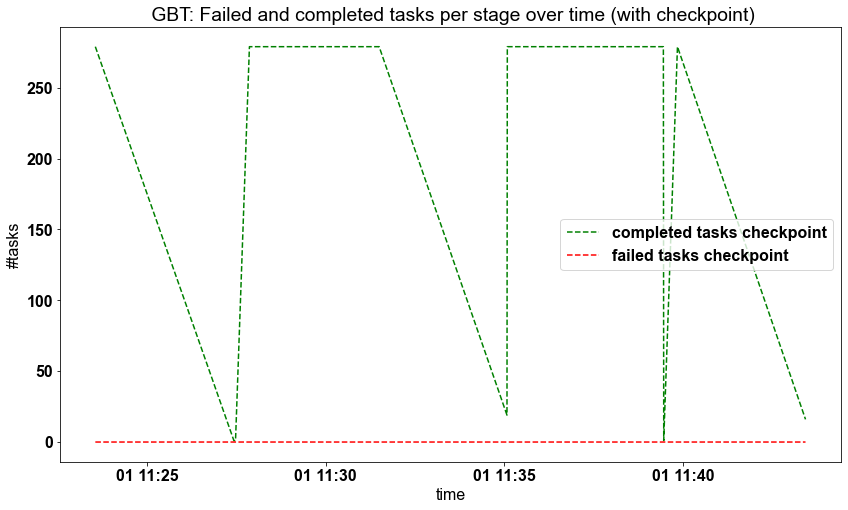

In [295]:
gbt_check_submission_time = gbt_check_df.select("submissionTime").toPandas()["submissionTime"]

gbt_check_complete_tasks = gbt_check_df.select("numCompleteTasks").toPandas()["numCompleteTasks"]
gbt_check_failed_tasks = gbt_check_df.select("numFailedTasks").toPandas()["numFailedTasks"]


fig = plt.figure(figsize=(14, 8))

plt.plot(gbt_check_submission_time, gbt_check_complete_tasks, color="green", linestyle="dashed", label="completed tasks checkpoint")
plt.plot(gbt_check_submission_time, gbt_check_failed_tasks, color="red", linestyle="dashed", label="failed tasks checkpoint")

plt.xlabel('time')
plt.ylabel('#tasks')
plt.title(' GBT: Failed and completed tasks per stage over time (with checkpoint)')
plt.legend()

plt.show()

### *Plot 6*: Analytics: Failed and completed tasks per stage over time (with checkpoint)
- number of tasks completed grows linearly without any failures

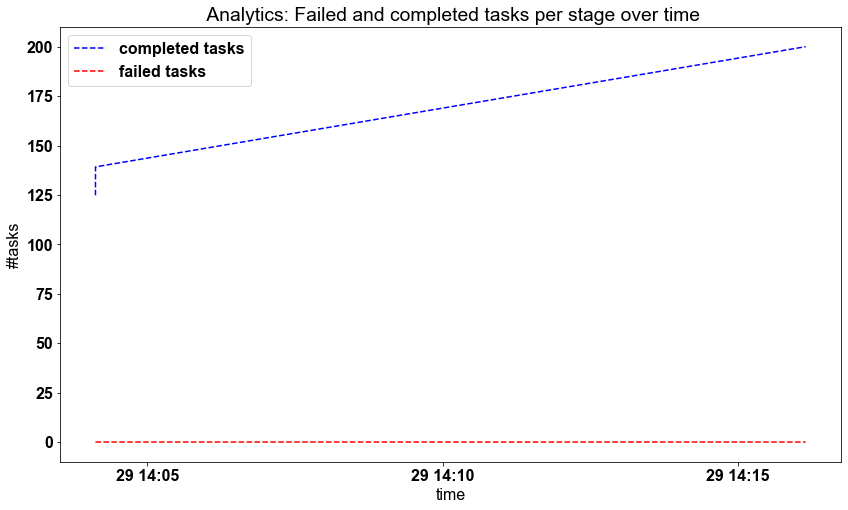

In [302]:
analytics_submission_time = analytics_df.select("submissionTime").toPandas()["submissionTime"]

analytics_complete_tasks = analytics_df.select("meanNumCompleteTasks").toPandas()["meanNumCompleteTasks"]
analytics_failed_tasks = analytics_df.select("meanNumFailedTasks").toPandas()["meanNumFailedTasks"]


fig = plt.figure(figsize=(14, 8))

plt.plot(analytics_submission_time, analytics_complete_tasks, color="blue", linestyle="dashed", label="completed tasks")
plt.plot(analytics_submission_time, analytics_failed_tasks, color="red", linestyle="dashed", label="failed tasks")

plt.xlabel('time')
plt.ylabel('#tasks')
plt.title(' Analytics: Failed and completed tasks per stage over time')
plt.legend()

plt.show()

### *Plot 7*: Analytics: Failed and completed tasks per stage over time (with checkpoint)

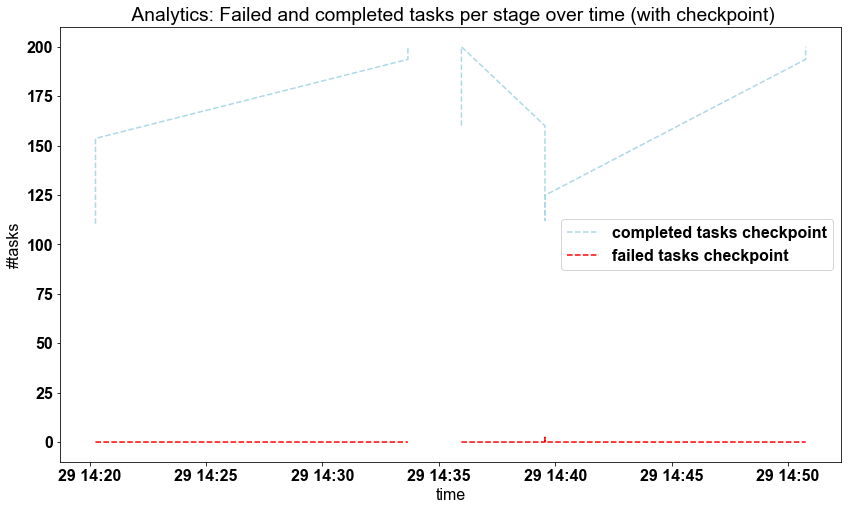

In [296]:
analytics_check_submission_time = analytics_check_df.select("submissionTime").toPandas()["submissionTime"]

analytics_check_complete_tasks = analytics_check_df.select("meanNumCompleteTasks").toPandas()["meanNumCompleteTasks"]
analytics_check_failed_tasks = analytics_check_df.select("meanNumFailedTasks").toPandas()["meanNumFailedTasks"]


fig = plt.figure(figsize=(14, 8))

plt.plot(analytics_check_submission_time, analytics_check_complete_tasks, color="lightblue", linestyle="dashed", label="completed tasks checkpoint")
plt.plot(analytics_check_submission_time, analytics_check_failed_tasks, color="red", linestyle="dashed", label="failed tasks checkpoint")

plt.xlabel('time')
plt.ylabel('#tasks')
plt.title(' Analytics: Failed and completed tasks per stage over time (with checkpoint)')
plt.legend()

plt.show()